In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, make_scorer, fbeta_score
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter, OrderedDict
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 
sns.set()

In [3]:
# make f2 scorer
f2 = make_scorer(fbeta_score, beta=2)
def f2_score(y_val, y_pred):
    y_val, y_pred = np.array(y_val), np.array(y_pred)
    return fbeta_score(y_val, y_pred, beta=2)

In [ ]:
# Load training and validation data without resampling and certain features
X_tr = pd.read_pickle('data/X_tr_f1.pkl')
X_val = pd.read_pickle('data/X_val_f1.pkl')
X_te = pd.read_pickle('data/X_te_f1.pkl')

y_tr = pd.read_pickle('data/y_tr_f1.pkl')
y_val = pd.read_pickle('data/y_val_f1.pkl')
y_te = pd.read_pickle('data/y_te_f1.pkl')

In [4]:
# Load training and validation data without resampling
X_tr = pd.read_pickle('data/X_tr_reg.pkl')
X_val = pd.read_pickle('data/X_val_reg.pkl')
X_te = pd.read_pickle('data/X_te_reg.pkl')

y_tr = pd.read_pickle('data/y_tr_reg.pkl')
y_val = pd.read_pickle('data/y_val_reg.pkl')
y_te = pd.read_pickle('data/y_te_reg.pkl')

In [5]:
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

In [6]:
X_tr_smote, y_tr_smote = SMOTE(random_state=20).fit_sample(X_tr, y_tr)
X_tr_ada, y_tr_ada = ADASYN(random_state=20).fit_sample(X_tr, y_tr)

In [7]:
y_tr.head()

591     0
1271    1
2013    0
559     1
1554    0
Name: shootings_abv_avg, dtype: int64

In [46]:
X_tr_aug = X_tr.drop(labels = ['SelfEmployed', 'Mnr_Vtg', 'ChildPoverty', 'VotingAgeCitizen'], axis = 1)
X_val_aug = X_val.drop(labels = ['SelfEmployed', 'Mnr_Vtg', 'ChildPoverty', 'VotingAgeCitizen'], axis = 1)
X_ve_aug = X_te.drop(labels = ['SelfEmployed', 'Mnr_Vtg', 'ChildPoverty', 'VotingAgeCitizen'], axis = 1)


In [47]:
X_tr_aug_ada, y_tr_aug_ada = ADASYN(random_state=20).fit_sample(X_tr_aug, y_tr)

In [9]:
# get baseline logistic regression model:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr_smote, y_tr_smote)
f1 = f1_score(lr.predict(X_val), y_val)
f2 = f2_score(y_val, lr.predict(X_val))
recall = recall_score(lr.predict(X_val), y_val)
print('f1 score: {} \nf2 score: {} \nrecall score: {}'.format(f1, f2, recall))

f1 score: 0.4362745098039216 
f2 score: 0.5862977602108037 
recall score: 0.30584192439862545


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
lr.feature_names

In [10]:
# get baseline random forest model
randomforest = RandomForestClassifier(n_estimators=500)
randomforest.fit(X_tr_smote, y_tr_smote)
f1 = f1_score(randomforest.predict(X_val), y_val)
f2 = f2_score(y_val, randomforest.predict(X_val))
recall = recall_score(randomforest.predict(X_val), y_val)
print('f1 score: {} \nf2 score: {} \nrecall score: {}'.format(f1, f2, recall))

f1 score: 0.4159292035398231 
f2 score: 0.4072790294627383 
recall score: 0.43119266055045874


In [ ]:
randomforest.feature_importances_

In [11]:
# get baseline decision tree
decisiontree = DecisionTreeClassifier(max_depth=5)
decisiontree.fit(X_tr_smote, y_tr_smote)
f1 = f1_score(decisiontree.predict(X_val), y_val)
recall = recall_score(decisiontree.predict(X_val), y_val)
print('f1 score: {} \nrecall score: {}'.format(f1, recall))

f1 score: 0.34920634920634924 
recall score: 0.25287356321839083


In [39]:
decisiontree.feature_importances_

array([0.05861742, 0.00635694, 0.00307356, 0.0694651 , 0.32316668,
       0.22332084, 0.        , 0.        , 0.01733621, 0.        ,
       0.        , 0.        , 0.01865021, 0.01963452, 0.        ,
       0.09373593, 0.        , 0.01441887, 0.        , 0.04334089,
       0.01982177, 0.03289079, 0.        , 0.        , 0.        ,
       0.04724526, 0.008925  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [52]:
# get baseline linear svm
linearsvc = LinearSVC()
linearsvc.fit(X_tr_ada, y_tr_ada)
f1 = f1_score(linearsvc.predict(X_val), y_val)
f2 = f2_score(y_val, linearsvc.predict(X_val))
recall = recall_score(linearsvc.predict(X_val), y_val)
print('f1 score: {} \nf2 score: {} \nrecall score: {}'.format(f1, f2, recall))

f1 score: 0.44337349397590353 
f2 score: 0.6005221932114883 
recall score: 0.3087248322147651


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
# get baseline svm
svc = SVC(gamma='scale', probability=True)
svc.fit(X_tr_smote, y_tr_smote)
f1 = f1_score(svc.predict(X_val), y_val)
f2 = f2_score(y_val, svc.predict(X_val))
recall = recall_score(svc.predict(X_val), y_val)
print('f1 score: {} \nf2 score: {} \nrecall score: {}'.format(f1, f2, recall))

f1 score: 0.4088397790055249 
f2 score: 0.5189340813464236 
recall score: 0.3020408163265306


In [ ]:
# get baseline KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr_ada, y_tr_ada)
f1 = f1_score(knn.predict(X_val), y_val)
recall = recall_score(knn.predict(X_val), y_val)
print('f1 score: {} \nrecall score: {}'.format(f1, recall))

In [14]:
# Get baseline XGBoost
xgb = GradientBoostingClassifier()
xgb.fit(X_tr_smote, y_tr_smote)
f1 = f1_score(xgb.predict(X_val), y_val)
f2 = f2_score(y_val, xgb.predict(X_val))
recall = recall_score(xgb.predict(X_val), y_val)
print('f1 score: {} \nf2 score: {} \nrecall score: {}'.format(f1, f2, recall))

f1 score: 0.3665338645418326 
f2 score: 0.38205980066445183 
recall score: 0.34328358208955223


In [ ]:
!conda install -c conda-forge rfpimp -y

In [42]:
from rfpimp import *

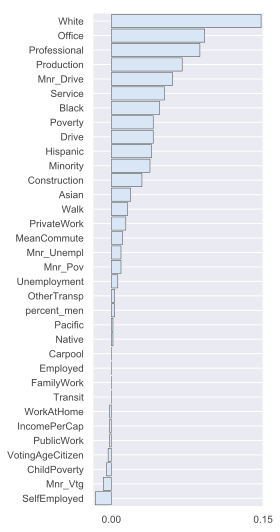

In [43]:
imp = importances(linearsvc, X_val, y_val)
viz = plot_importances(imp)
viz.view()

In [40]:
for i in sorted(zip(X_val, randomforest.feature_importances_), key = lambda x: x[1]):
    print(i)

('Minority', 0.014946363084517245)
('Mnr_Vtg', 0.016804514486761544)
('Mnr_Drive', 0.017007158353818563)
('White', 0.018314487505378313)
('Mnr_Unempl', 0.01846349899335901)
('IncomePerCap', 0.02058477339657894)
('PublicWork', 0.020985907922382262)
('Employed', 0.021128082045595537)
('Mnr_Pov', 0.021673049178902917)
('Construction', 0.022340607284786814)
('WorkAtHome', 0.023097995871657243)
('VotingAgeCitizen', 0.023108378626738424)
('ChildPoverty', 0.02375415652674582)
('Carpool', 0.0238570287257261)
('Production', 0.023880249251007714)
('PrivateWork', 0.023893254001082796)
('Unemployment', 0.024369969780570908)
('Professional', 0.02484715181996974)
('OtherTransp', 0.026517570779461378)
('Poverty', 0.026687399222437812)
('Hispanic', 0.027555012121590013)
('Service', 0.02854649091366067)
('Walk', 0.02868386175901053)
('percent_men', 0.029045890585953683)
('Black', 0.030224420489173644)
('Drive', 0.03039906389102865)
('MeanCommute', 0.037716092427734306)
('SelfEmployed', 0.03907237938803

In [ ]:
X_val.columns

In [ ]:
for i in zip(X_val, randomforest.feature_importances_):
    print(i)

# ROC Curves

In [56]:
models = [randomforest, lr_best_estimator]

In [57]:
# fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val)[:,1])

ROC AUC score =  0.7242042584508339
ROC AUC score =  0.7475872681352134


Text(0.5, 1.0, 'ROC curve for Predicting Police Shootings')

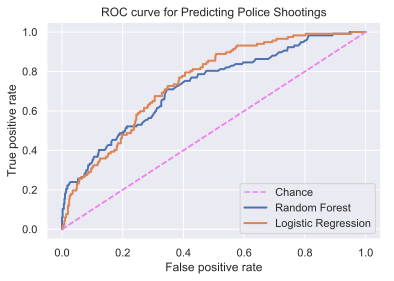

In [58]:
plt.plot([0,1],[0,1],c='violet',ls='--')
for model in models:
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr,lw=2)

    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(['Chance', 'Random Forest', 'Logistic Regression'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Predicting Police Shootings')

In [ ]:
for item in sorted(zip(list(X_tr.columns), list(randomforest.feature_importances_)), 
                   key=lambda x: x[1]):
    print(item)

In [ ]:
for item in sorted(zip(list(X_tr.columns), list(decisiontree.feature_importances_)), 
                   key=lambda x: x[1]):
    print(item)

In [ ]:
from matplotlib.pyplot import scatter

In [ ]:
np.corrcoef(X_tr.SelfEmployed, y_tr)

In [ ]:
scatter(x=X_tr.Hispanic, y=y_tr)

# Try Random Forest with the top 10 features

In [ ]:
X_tr_top15 = X_tr.drop(labels = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 
                                 'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
                                 'Professional', 'Service', 'Office', 'Construction', 'Production', 
                                 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
                                 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
                                 'FamilyWork', 'Unemployment', 'percent_men'], axis = 1)

X_val_top15 = X_val.drop(labels = ['Pacific', 'FamilyWork', 'OtherTransp', 'Native', 'IncomePerCap',
                                'WorkAtHome', 'Employed', 'Employed', 'Carpool', 'PublicWork',
                                'Transit', 'Professional', 'ChildPoverty', 'VotingAgeCitizen', 
                                'Production'], axis = 1)

In [ ]:
X_tr_top10 = X_tr[['Pacific', 'Asian', 'Native', 'Transit', 'Office', 
                  'Black', 'Hispanic', 'MeanCommute', 'White', 'SelfEmployed']]

X_val_top10 = X_val[['Pacific', 'Asian', 'Native', 'Transit', 'Office', 
                  'Black', 'Hispanic', 'MeanCommute', 'White', 'SelfEmployed']]

In [ ]:
X_tr_top10.columns

In [ ]:
# random forest with 15 predictive features
rf10 = RandomForestClassifier(n_estimators=100)
rf10.fit(X_tr_top10, y_tr)
f1 = f1_score(rf10.predict(X_val_top10), y_val)
recall = recall_score(rf10.predict(X_val_top10), y_val)
print('f1 score: {} \nrecall score: {}'.format(f1, recall))

In [ ]:
pickle.dump(rf10, open('rf10.pkl', 'wb'))    

In [ ]:
plt.plot([0,1],[0,1],c='violet',ls='--')
fpr, tpr, thresholds = roc_curve(y_val, rf15.predict_proba(X_val_top15)[:,1])
plt.plot(fpr, tpr,lw=2)

print("ROC AUC score = ", roc_auc_score(y_val, rf15.predict_proba(X_val_top15)[:,1]))

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(['Chance', 'Random Forest'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Predicting Police Shootings')

# Try GridSearch for Logistic Regression

In [24]:
penalty = ['l2']
C = [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
solver = ['newton-cg', 'lbfgs', 'sag']
max_iter = [100, 150, 200]

param_grid = dict(penalty = penalty, C = C, solver = solver, max_iter = max_iter)
lr_grid_search = LogisticRegression()
lr_grid = GridSearchCV(lr_grid_search, param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)
lr_grid.fit(X_tr_ada, y_tr_ada)

lr_grid_predictions = lr_grid.predict(X_val)
lr_best_params = lr_grid.best_params_
lr_best_estimator = lr_grid.best_estimator_

lr_best_cm = confusion_matrix(y_val,lr_grid_predictions)
lr_best_cr = classification_report(y_val,lr_grid_predictions)

print(lr_best_params, lr_best_estimator, lr_best_cm, lr_best_cr)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    5.2s


{'C': 3.5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'} LogisticRegression(C=3.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False) [[307 204]
 [ 26  91]]               precision    recall  f1-score   support

           0       0.92      0.60      0.73       511
           1       0.31      0.78      0.44       117

   micro avg       0.63      0.63      0.63       628
   macro avg       0.62      0.69      0.58       628
weighted avg       0.81      0.63      0.67       628



[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   11.7s finished


In [35]:
f2 = f2_score(y_val, lr_best_estimator.predict(X_val))
print(f2)

0.5963302752293579


# Try GridSearch for Linear SVM

In [51]:
penalty = ['l2']
loss = ['hinge', 'squared_hinge']
C = [0.25, 0.5, 0.75, 1]
intercept_scaling  = [0.25, 0.5, 0.75, 1]


param_grid = dict(penalty = penalty, C = C, loss=loss, intercept_scaling=intercept_scaling)
l_svm_grid_search = LinearSVC()
l_svm_grid = GridSearchCV(l_svm_grid_search, param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)
l_svm_grid.fit(X_tr_ada, y_tr_ada)

l_svm_grid_predictions = l_svm_grid.predict(X_val)
l_svm_best_params = l_svm_grid.best_params_
l_svm_best_estimator = l_svm_grid.best_estimator_

l_svm_best_cm = confusion_matrix(y_val,l_svm_grid_predictions)
l_svm_best_cr = classification_report(y_val,l_svm_grid_predictions)

print(l_svm_best_params, l_svm_best_estimator, l_svm_best_cm, l_svm_best_cr)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s


{'C': 0.25, 'intercept_scaling': 0.25, 'loss': 'hinge', 'penalty': 'l2'} LinearSVC(C=0.25, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=0.25, loss='hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) [[273 238]
 [ 24  93]]               precision    recall  f1-score   support

           0       0.92      0.53      0.68       511
           1       0.28      0.79      0.42       117

   micro avg       0.58      0.58      0.58       628
   macro avg       0.60      0.66      0.55       628
weighted avg       0.80      0.58      0.63       628



[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   10.9s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
f2 = f2_score(y_val, l_svm_best_estimator.predict(X_val))
print(f2)

0.5952380952380952


# Try GridSearch for Random Forest

In [ ]:
X_tr.columns

In [60]:
n_estimators = [600,700,800,900,1000]
criterion = ['gini', 'entropy']
max_depth = [5,6,7]

param_grid = dict(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth)
random_forest_grid_search = RandomForestClassifier()
random_forest_grid = GridSearchCV(random_forest_grid_search, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
random_forest_grid.fit(X_tr_ada, y_tr_ada)

random_forest_grid_predictions = random_forest_grid.predict(X_val)
random_forest_best_params = random_forest_grid.best_params_
random_forest_best_estimator = random_forest_grid.best_estimator_

random_forest_best_cm = confusion_matrix(y_val,random_forest_grid_predictions)
random_forest_best_cr = classification_report(y_val,random_forest_grid_predictions)

print(random_forest_best_params, random_forest_best_estimator, random_forest_best_cm, random_forest_best_cr)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 1000} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) [[362 149]
 [ 53  64]]               precision    recall  f1-score   support

           0       0.87      0.71      0.78       511
           1       0.30      0.55      0.39       117

   micro avg       0.68      0.68      0.68       628
   macro avg       0.59      0.63      0.58       628
weighted avg       0.77      0.68      0.71       628



In [ ]:
print(random_forest_best_cr)

In [ ]:
random_forest_y_score = random_forest_grid.predict_proba(X_val)[:, 1]
random_forest_grid_fpr, random_forest_grid_tpr, auc_thresholds = roc_curve(y_val, random_forest_y_score)
roc_auc_random_forest_grid = auc(random_forest_grid_fpr, random_forest_grid_tpr)
print(auc(random_forest_grid_fpr, random_forest_grid_tpr))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, random_forest_grid.best_estimator_.predict(X_val))

In [ ]:
pickle.dump(random_forest_grid, open('rf_model.pkl', 'wb'))    

# Try GridSearch for XG Boost

In [ ]:
parameter_grid={
    "loss":["deviance"],
    "learning_rate": [0.2],
    "criterion": ["friedman_mse"],
    "n_estimators":[300, 400, 500],
    "max_depth":[4,5,6],
    "max_features": ["sqrt", "log2"]
    }

xgb_grid = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'recall', verbose= 2)
xgb_grid.fit(X_tr, y_tr)

xgb_predictions = xgb_grid.predict(X_val)
xgb_best_params = xgb_grid.best_params_
xgb_best_estimator = xgb_grid.best_estimator_

xgb_best_cm = confusion_matrix(y_val, xgb_predictions)
xgb_best_cr = classification_report(y_val, xgb_predictions)

print(xgb_best_params, xgb_best_estimator, xgb_best_cm, xgb_best_cr)


In [ ]:
xgb_predictions = xgb_grid.predict(X_val)
xgb_best_params = xgb_grid.best_params_
xgb_best_estimator = xgb_grid.best_estimator_

xgb_best_cm = confusion_matrix(y_val, xgb_predictions)
xgb_best_cr = classification_report(y_val, xgb_predictions)

print(xgb_best_params, xgb_best_estimator, xgb_best_cm, xgb_best_cr)

In [ ]:
xgb_y_score = xgb_grid.predict_proba(X_val)[:, 1]
xgb_grid_fpr, xgb_grid_tpr, auc_thresholds = roc_curve(y_val, xgb_y_score)
roc_auc_xgb_grid = auc(xgb_grid_fpr, xgb_grid_tpr)
print(auc(xgb_grid_fpr, xgb_grid_tpr))

In [ ]:
type(xgb_best_estimator)

In [ ]:
pickle.dump(xgb_best_estimator, open('xgb_model.pkl', 'wb'))    

# Flask Stuff

In [ ]:
# Get original data
df = pd.read_pickle('data/combined_data_cleaned_corrected.pkl')

In [ ]:
cols = df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1).columns.values

In [ ]:
# This is what the data will look like coming in:
a = dict(df.loc[1204,:].drop(labels = ['shootings_abv_avg', 'County']))
a

In [ ]:
# This is how we can convert it into a dataframe
b = pd.DataFrame(a, index=[0])

In [ ]:
# Import our scaler because we will need to apply it
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [ ]:
b_transformed = scaler.transform(b)
b_transformed = pd.DataFrame(b_transformed, columns = cols)

In [ ]:
xgb_best_estimator.predict(b_transformed)[0]

In [ ]:
feature_dict = {'Hispanic': 28, 'White': , 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'percent_men'}

In [ ]:
def make_prediction(feature_dict):
    """
    Input:
    feature_dict: a dictionary of the form {"feature_name": "value"}

    Function makes sure the features are fed to the model in the same order the
    model expects them.

    Output:
    Returns (x_inputs, probs) where
      x_inputs: a list of feature values in the order they appear in the model
      probs: a list of dictionaries with keys 'name', 'prob'
    """
    